# Muhammad Hisham AL Hanoun


 ----------------------------------------------------------------------------------------------------------
 ----------------------------------------------------------------------------------------------------------
 ----------------------------------------------------------------------------------------------------------
 ----------------------------------------------------------------------------------------------------------

# Generalized 2D TrussSolver
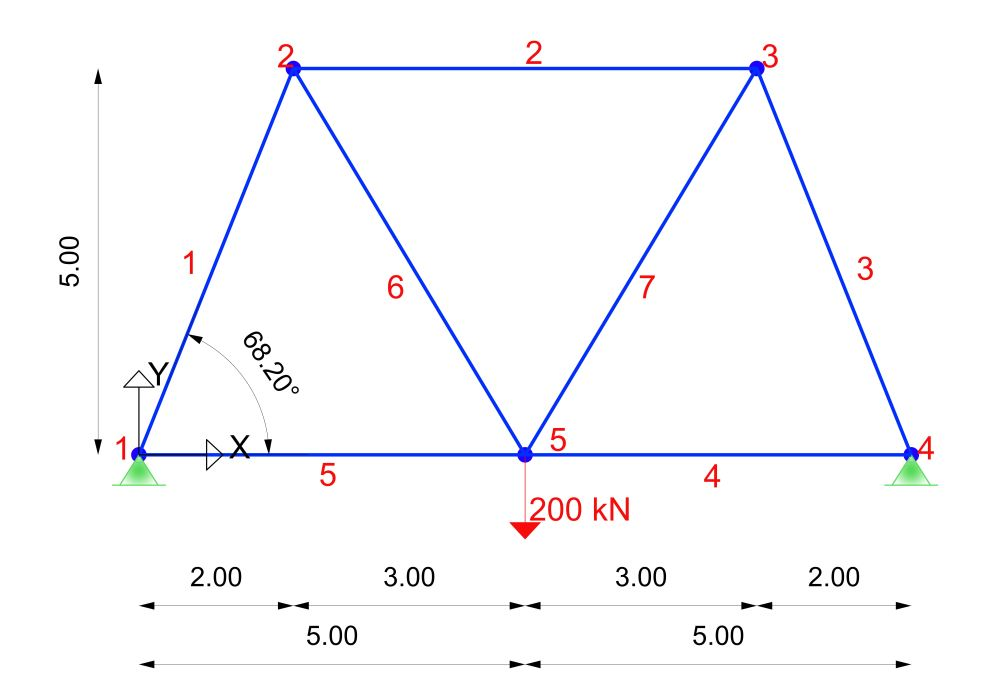

# Required Libraries

In [ ]:
# Import Required Libraries
import numpy as np 
import copy
from numpy.linalg import norm
import matplotlib.pyplot as plt


# 2D Truss Construction

## Input Data 

In [ ]:
# ================================= Start of Model Defention ================================ #

# Define the Coordinate System
x_axis = np.array([1,0])
y_axis = np.array([0,1])

# Define the model ( m )
nodes               = { 1:[0,0], 2:[2.0,5.0], 3:[8.0,5.0], 4:[10,0], 5:[5,0]}

nodesR              = { 1:[0, 0], 4:[10, 0]}

degrees_of_freedom  = { 1:[1,2], 2:[3,4], 3:[5,6], 4:[7,8], 5:[9,10]}
    
elements            = { 1:[1,2], 2:[2,3], 3:[3,4], 4:[4,5], 5:[1,5], 6:[2,5], 7:[3,5]}
    
restrained_dofs     = [ 1, 2, 7, 8]
    
# Appleid forces ( N )    
forces              = { 1:[0,0], 2:[0,0], 3:[0,0], 4:[0,0], 5:[0,-200000]}

# Material properties -  Steel  (density N/m³, young_modulus N/m²)
density             = { 1:78500, 2:78500, 3:78500, 4:78500, 5:78500, 6:78500, 7:78500}
    
young_modulus        = { 1:200*10**9, 2:200*10**9, 3:200*10**9, 4:200*10**9, 5:200*10**9, 6:200*10**9, 7:200*10**9}

# Geometric properties ( m² )
area                = { 1:0.005, 2:0.005, 3:0.005, 4:0.005, 5:0.005, 6:0.005, 7:0.005}

ndofs               = 2 * len(nodes)

model_settings = {'x_axis':x_axis, 'y_axis':y_axis, 'nodes':nodes, 'degrees_of_freedom':degrees_of_freedom,
                 'elements':elements, 'restrained_dofs':restrained_dofs, 'forces':forces, 'ndofs':ndofs,
                 'density':density, 'young_modulus':young_modulus, 'area':area}

# =================================End of Model Defention================================ #
  

## Points / Nodes / Elements

In [ ]:
def points(element):
    
# Identifying the current element nodes    
    from_node        = elements[element][0]
    to_node          = elements[element][1]

# Getting the nodes' coordinates    
    from_node_xy     = np.array(nodes[from_node])
    to_node_xy       = np.array(nodes[to_node])

# Getting the nodes' glbal degree of freedom   
    u1              = degrees_of_freedom[from_node][0]
    v1              = degrees_of_freedom[from_node][1] 
    u2              = degrees_of_freedom[to_node][0]
    v2              = degrees_of_freedom[to_node][1]        
    UV              = np.array([u1 , v1, u2 , v2])
    return from_node, to_node, from_node_xy, to_node_xy, UV


            
def plot_nodes(nodes):
# Plotting the nodes of the 2D truss    
    x       = [i[0] for i in nodes.values()]
    y       = [i[1] for i in nodes.values()]
    xR      = [i[0] for i in nodesR.values()]
    yR      = [i[1] for i in nodesR.values()]       
    return x, y, xR, yR    



def draw_element(from_node_xy, to_node_xy):
# Plotting the elements of the 2D truss 

    x1 = from_node_xy[0]
    y1 = from_node_xy[1]
    x2 = to_node_xy[0]
    y2 = to_node_xy[1]    
    return x1, y1, x2, y2                

   


## Plotting the Constructed 2D Truss

In [ ]:
fig  = plt.figure()
axes = fig.add_axes([2,2,2,2])
axes.set_xlabel('Dimension in X direction (m)')
axes.set_ylabel('Dimension in Y direction (m)')
axes.set_title('2DTruss Geometry')
axes.grid()
fig.gca().set_aspect('equal', adjustable='box')

for element in elements:
    _, _, from_node_xy, to_node_xy, _                    = points(element)
    x1, y1, x2, y2                                                      = draw_element(from_node_xy, to_node_xy)
    axes.plot([x1,x2],[y1,y2], color= "b", linestyle = "-", linewidth=2)    


x, y, xR, yR = plot_nodes(nodes)
offset = 0.05

for i, location in enumerate(zip(x,y)):
    axes.scatter(x,y,   marker= "o", c = "r", s = 15, zorder=5)
    axes.scatter(xR,yR, marker= "^", c = "lime", s = 150, zorder=6)
    axes.annotate(i+1,(location[0]+offset,location[1]+offset) )
   

# 2D Truss Pre processing 

## Stiffness and Force Matrices Formulation

In [ ]:
def direction_cosine(vec1,vec2):
    return np.dot(vec1,vec2) / (norm(vec1) * norm(vec2))

def rotation_matrix(element_vector, x_axis,y_axis):
    
    cos_theta = direction_cosine(element_vector, x_axis)
    sin_theta = direction_cosine(element_vector, y_axis)
    
    return np.array([[cos_theta,sin_theta,0,0],[0,0,cos_theta,sin_theta]])


def get_matrices(model_settings):
    
    K = np.zeros([ndofs,ndofs])
    
    
    for element in elements:
        
        
        _, _, from_node_xy, to_node_xy, UV                             = points(element)
        element_vector                                                 = to_node_xy - from_node_xy
        length                                                         = norm(element_vector)
        
        A     = model_settings["area"][element]
        
        E     = model_settings["young_modulus"][element]
        
        Fk   = E * A / length
        
        k = np.array([[1,-1],[-1,1]])
        
        tau = rotation_matrix(element_vector, x_axis, y_axis)
        
        k_r = tau.T.dot(k).dot(tau)
        
        index = UV-1
        # index for element 1 = [0, 1, 4, 5]
        
        
        B = np.zeros([4,ndofs])
        
        for i in range(4):
            B[i,index[i]] = 1
       
        K_rG = B.T.dot(k_r).dot(B)
        
        K = K + (Fk*K_rG)
        
        Kp = copy.copy(K)
        
    F = []
    for f in forces.values():
        F.append(f)
        
    remove_indices = np.array(model_settings["restrained_dofs"])-1
    
    K = np.delete(K,remove_indices,0)
    K = np.delete(K,remove_indices,1)
    
    F = np.delete(F,remove_indices)
    
    return K, F, Kp
        
K, F, Kp = get_matrices(model_settings)    



# 2D Truss Post-proccessing 

## Solving for the Displacements 

In [ ]:
K, F, Kp = get_matrices(model_settings)

# Solving for the nodal displacements

disp = np.linalg.inv(K).dot(F) 

## Solving for Reactions

In [ ]:
dispG = np.zeros(ndofs)

remove_indices = np.array(model_settings["restrained_dofs"])-1

#print(remove_indices)

cR = 0

for i in np.arange(ndofs):
    
    if i in remove_indices:
        dispG[i] = 0
        
    else:
        dispG[i] = disp[cR]
        cR = cR+1
        
dispG = np.array([dispG]).T

FG = np.matmul(Kp,dispG)



## Solving for the Memeber Forces

In [ ]:
element_forces = np.array([])


for element in elements:
        
        _, _, from_node_xy, to_node_xy, UV                             = points(element)
        element_vector                                                 = to_node_xy - from_node_xy
        tau                                                            = rotation_matrix(element_vector,x_axis,y_axis)
        
        length                                                         = norm(element_vector)
        
        index                                                          = UV -1 
        
        B = np.zeros((4,ndofs))
        
        for i in range(4):
            B[i,index[i]] = 1
            
        ele_disp   = B.dot(dispG)
        ele_disp_r = tau.dot(ele_disp) 
        
        F_axl = (area[element] * young_modulus[element] / length) * (ele_disp_r[1]-ele_disp_r[0])
        
        element_forces = np.append(element_forces,F_axl)



## Plotting the Deformed Shape

In [ ]:
fig  = plt.figure()
axes = fig.add_axes([2,2,2,2])
axes.set_xlabel('Dimension in X direction (m)')
axes.set_ylabel('Dimension in Y direction (m)')
axes.set_title('2DTruss Geometry')
axes.grid()
fig.gca().set_aspect('equal', adjustable='box')
s_fa = 150

for element in elements:
    _, _, from_node_xy, to_node_xy, UV                                  = points(element)
    x1, y1, x2, y2                                                      = draw_element(from_node_xy, to_node_xy)
    
    
    
    
    index = UV-1
    
    ia = index[0]
    ib = index[1]
    ja = index[2]
    jb = index[3]
    
    
    axes.plot([x1,x2],[y1,y2], color= "b", linestyle = "-", linewidth=2) 
    axes.plot([x1+dispG[ia]*s_fa,x2+dispG[ja]*s_fa], [y1+dispG[ib]*s_fa,y2+dispG[jb]*s_fa], color= "y", linestyle = "--", linewidth=1)   


x, y, xR, yR = plot_nodes(nodes)
offset = 0.05

for i, location in enumerate(zip(x,y)):
    axes.scatter(x,y,   marker= "o", c = "r", s = 15, zorder=5)
    axes.scatter(xR,yR, marker= "^", c = "lime", s = 150, zorder=6)
    axes.annotate(i+1,(location[0]+offset,location[1]+offset) )

# 2D Truss Processing Summary

In [ ]:
print("Nodal Displacements")

for i, node in enumerate(nodes):
    
    
    ix = 2*(i+1)-2
    iy = 2*(i+1)-1
    
    ux = dispG[ix,0]
    uy = dispG[iy,0]
    
    print( f"Node{i+1} , Ux = {round(ux,5)*1000} mm ,Uy = {round(uy,5)*1000} mm")
    
    
print("------------------------------------------------------------------------------------------")


print("Reactions")

for i in range(len(remove_indices)):
    
    index = remove_indices[i]
    Force = FG[index][0]
    
    print(f"reaction at DoF {i+1} is {round((Force/1000),2)} kN")
    
    
print("------------------------------------------------------------------------------------------")

print("Element Forces ( + is Tension , - is Compression )")    

for n, ele in enumerate(elements):
    ele_num = n+1
    node_i=elements[ele][0]
    node_j=elements[ele][1]
    Faxl=round(element_forces[n]/1000,1)
    
    
    print(f"Force in element {ele_num} (nodes {node_i} to {node_j}) is: {Faxl} kN")

